# Tarea 5 - RNN GRU LSTM

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Tópicos AI 2
##### Dr. Luis Eduardo Falcón Morales

---

## Carlos E. Hdz Rincón - A01181616

# Introducción

Esta Tarea se podrá resolver de manera individual o en equipos de máximo 3 integrantes.

Esta Tarea se basa en los datos de Kaggle, Question Classification: Android or iOS: https://www.kaggle.com/xhlulu/question-classification-android-or-ios?select=train.csv

Podrás encontrar la descipción de los datos en dicha liga. Descarga los archivos `train.csv`, `val.csv` y `test.csv`.


# Prerequisitos y preparamiento de ambiente

## Instalación de dependencias

Descomentamos la siguiente línea para poder instalar las dependencias de Python necesarias.

In [1]:
#!pip install keras tensorflow matplotlib numpy pandas

## Extracción de datos a partir del archivo ZIP

In [2]:
# Set this variable to the root path of where the CSV files are located
#%env DATA_LOCATION=/workspace/jupyter_workspace/datasets/AndroidOriOS
%env DATA_LOCATION=/content/drive/MyDrive/Datasets/AndroidOrIos
!echo $DATA_LOCATION

#!unzip "$DATA_LOCATION/kaggle-dataset.zip" -d "$DATA_LOCATION"

!ls -lah "$DATA_LOCATION"

env: DATA_LOCATION=/content/drive/MyDrive/Datasets/AndroidOrIos
/content/drive/MyDrive/Datasets/AndroidOrIos
total 71M
-rw------- 1 root root  19M Apr 20 19:59 kaggle-dataset.zip
-rw------- 1 root root 7.8M Oct 29 16:43 test.csv
-rw------- 1 root root  37M Oct 29 16:43 train.csv
-rw------- 1 root root 7.7M Oct 29 16:44 valid.csv


## Imports

In [3]:
from IPython.display import display

import time
import random
import os
import re

from collections import Counter

import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, RNN, GRU, SimpleRNN

import tensorflow as tf

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

## Tools

In [4]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

In [5]:
def model_2_pkl(model, filename: str):
    """Exports a model to PKL format"""
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    """Loads a model from a PKL file"""
    return pickle.load(open(filename, 'rb'))

def train_model(model_to_fit: tf.keras.models.Model,
                epochs: int,
                train_data: tuple,
                validation_data: tuple,
                callbacks: list = None,
                batch_size=None):

    t = time.process_time()
    
    trained_model = model_to_fit.fit(train_data[0],
                                     train_data[1],
                                     validation_data=validation_data,
                                     epochs=epochs,
                                     callbacks=callbacks,
                                     batch_size=batch_size)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model

def graph_loss_accuracy(h_model,
                        subtitle: str = ""):
    
    num_records = len(h_model.history["accuracy"])
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,num_records),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,num_records),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(y_pred,
                                    y_real,
                                    labels: list=None):
    
    y_pred = np.round(y_pred).astype(int)

    print_marquee("Classification Report")
    print(classification_report(y_real,
                                y_pred,
                                target_names=labels))
    
    print_marquee("Confusion Matrix")
    print(confusion_matrix(y_real,
                           y_pred))


def evaluate_model(model_to_fit: tf.keras.models.Model,
                   epochs: int,
                   train_tuple: tuple,
                   validation_tuple: tuple,
                   test_tuple: tuple = None,
                   callbacks: list = None,
                   batch_size = None,
                   labels: list = None) -> tf.keras.models.Model:

    trained_model_history = train_model(model_to_fit,
                                epochs,
                                train_tuple,
                                validation_tuple,
                                callbacks=callbacks,
                                batch_size=batch_size)
    print_marquee("Model Summary")                                
    model_to_fit.summary()

    print_marquee("Validation Dataset Confusion Matrix")

    val_model_predictions = model_to_fit.predict(validation_tuple[0],
                                                 batch_size=batch_size)
    
    print_dataset_prediction_report(val_model_predictions,
                                    validation_tuple[1],
                                    labels)


    if test_tuple:

        print_marquee("Test Dataset Confusion Matrix")

        test_model_predictions = model_to_fit.predict(test_tuple[0],
                                                      batch_size=batch_size)
        
        print_dataset_prediction_report(test_model_predictions,
                                        test_tuple[1],
                                        labels)

    print_marquee("Train/Val Accuracy and Loss graphs")

    # If using early stopping, it might be the case that we used less epochs than
    #  requested
    subtitle = f"Epochs: {len(trained_model_history.history['accuracy'])}"
    
    graph_loss_accuracy(trained_model_history,
                        subtitle=subtitle)
    
    return model_to_fit, trained_model_history

# Parte I: Lecturas 

Realiza un resumen de máximo una cuartilla cada una de las siguientes tres lecturas:
1. A Systematic Review on Stopword Removal Algorithms: http://www.ijfrcsce.org/index.php/ijfrcsce/article/view/1499
1. Pulling Out the Stops: Rethinking Stopword Removal for Topic Models: https://www.aclweb.org/anthology/E17-2069.pdf
1. Normalizing Text using Language Modelling based on Phonetics and String Similarity: https://arxiv.org/abs/2006.14116

---
Resúmenes encontrados en un PDF anexo.

# Parte II: Pre-procesamiento con Body y sin excluir stopwords.

## Carga de datos

In [6]:
data_root_location = os.environ["DATA_LOCATION"]

train_data = pd.read_csv(f"{data_root_location}/train.csv")
val_data = pd.read_csv(f"{data_root_location}/valid.csv")
test_data = pd.read_csv(f"{data_root_location}/test.csv")

print_marquee("Train")
display(train_data.head(5))
display(train_data.info())

print_marquee("Val")
display(val_data.head(5))
display(val_data.info())

print_marquee("Test")
display(test_data.head(5))
display(test_data.info())




*********
* Train *
*********


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,197234,Drop\stop mobile data connection (non-wifi) by...,<p>Can I set Android 4.4.2 to drop mobile data...,0,34,android,0
1,114800,How to automatically crop text messages when S...,<p>Is there a way to prevent the Messages app ...,0,836,android,0
2,124532,Can't find text message that was to a group,<p>When John Doe texts to a group that include...,1,28,android,0
3,193875,Can't store contacts on my Android phone,<p>I was going through all of my installed app...,0,158,android,0
4,50332,Dropbox on Samsung Galaxy - where is the Setti...,"<p>On a Sony Xperia, the settings button in Dr...",1,963,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51370 entries, 0 to 51369
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         51370 non-null  int64 
 1   Title      51370 non-null  object
 2   Body       51370 non-null  object
 3   Score      51370 non-null  int64 
 4   ViewCount  51370 non-null  int64 
 5   Label      51370 non-null  object
 6   LabelNum   51370 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.7+ MB


None



*******
* Val *
*******


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,282570,How to erase my iPhone photos completely?,<p>I decided to delete all of my iPhone's phot...,1,95,ios,1
1,151903,How can i Downgrade my Lg G Flex 2?,<p>Is it possible for me to downgrade to kitka...,0,695,android,0
2,16128,How can I make 1Password for Android log in wi...,<p>I have a Droid X and have just installed 1P...,1,586,android,0
3,33177,Handwrite / draw on a text document,<p>Is there an Android app that enables hand-w...,0,7340,android,0
4,65171,"How to turn off ""applying profile"" and ""profil...",<p>Whenever a new profile is applied there is ...,0,519,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11008 entries, 0 to 11007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         11008 non-null  int64 
 1   Title      11008 non-null  object
 2   Body       11008 non-null  object
 3   Score      11008 non-null  int64 
 4   ViewCount  11008 non-null  int64 
 5   Label      11008 non-null  object
 6   LabelNum   11008 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 602.1+ KB


None



********
* Test *
********


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,202290,How to disable usage of background data of all...,<p>Some networks charges high in cellular data...,1,5785,android,0
1,151626,Low space On my Android,<p>I have a LG android and I bought a sd card ...,1,130,android,0
2,129401,Voice Memos (ios app) recording to Google Drive,<p>Is there any way to upload the Voice Memos ...,2,36111,ios,1
3,332306,Transfer IPA file to iPhone,<p>I'm using Cydia Impactor and wish to copy a...,0,478,ios,1
4,34587,"Can't move any applications to SD Card- ""Could...",<p>I'm trying to move any application that I i...,3,3895,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11008 entries, 0 to 11007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         11008 non-null  int64 
 1   Title      11008 non-null  object
 2   Body       11008 non-null  object
 3   Score      11008 non-null  int64 
 4   ViewCount  11008 non-null  int64 
 5   Label      11008 non-null  object
 6   LabelNum   11008 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 602.1+ KB


None

## 2

Realiza un proceso de limpieza de la columna `Body` del conjunto de entrenamiento. Aplica las expresiones regulares que consideres adecuadas, sin excluir las Stopwords.

NOTA: Deberás decidir las expresiones regulares o signos ortográficos a considerar dentro del proceso de limpieza, pero recuerda que debes decidirlo procesando únicamente los datos de entrenamiento. Y una vez definido, lo aplicas directamente al conjunto de validación.

---


Primero tomamos un ejemplo aleatorio para ver cómo se ve el texto.

In [7]:
train_data["Body"][1988]

'<p>I have a GT-I9195 running Lollipop 5.1.1 (currently PAC-ROM) which in theory has 8GB of internal memory. However, I can\'t seem to track down what exactly has happened to all that space. With a paltry 100 or so apps (including system essentials) installed, the phone starts reporting it\'s out of space until I move apps to the external MicroSD card. The problem persisted even through the custom ROM installation and subsequent recent ROM update as well as a few factory resets/cache wipes/etc. It\'s been an issue for nearly 8 months now, and periodically I\'ve trawled the Internet for suggestions and clues but without making any real progress.</p>\n\n<p>It seems to me as if a large chunk of space on the phone\'s memory is simply inaccessible and unused. Is this possible? How can I delve deeper into what\'s going on?</p>\n\n<p>I\'ve included the output of a df command in terminal emulator below. I notice that there seem to be duplicates of the internal memory /storage/emulated/0 and /s

Podemos confirmar que el texto tiene tags HTML incluso con atributos, además podemos también ver que hay caracteres de salto de línea. Además, vemos que el texto posee signos de puntuación como puntos, comas y paréntesis.

Debemos preservar la infomación que esté entre paréntesis, pero debemos eliminar los tags HTML y todos los atributos que estén dentro de ellos ya que no proporcionan información significativa para la extracción de features.

Los tags como `<strong></strong>` poseen texto entre ellos que sí será interesante conservar, pero debemos tener especial cuidado de remover todo lo que se encuentre entre los tags `<code></code>` ya que posee código que no aportará mucho a nuestro modelo.

Debemos tener también cuidado en que al remover las palabras inválidas no agreguemos más espacios en blanco entre las palabras y, de hecho, debemos remover cualquier espacio extra que ya se encuentre en el texto.

Para hacer la limpieza haremos lo siguiente en el siguiente orden:

1. Remover todos los tags que contengan código (`<code></code>`)
1. Remover todos los tags HTML y su contenido que en ellos, pero preservar el contenido entre los tags (`<p>, <strong>`, etc.)
1. Quitar todos los símbolos de salto de línea que se encuentran en el texto.
1. Quitar todos los caracteres que no sean alfanuméricos a excepción de los espacios en blanco.
1. Quitar todo el espacio extra que pueda haber entre todas las palabras.
1. Pasar todo el texto a minúsculas para poder procesar tokens más consistentemente.

In [8]:
def clean_text(txt: str) -> str:
    # Remove <code> tags make sure that the . char matches all characters
    code_regex = re.compile("<code>.*?<\/code>", re.DOTALL)
    txt = re.sub(code_regex, "", txt)

    # Remove HTML
    html_regex = re.compile('<.*?>')
    txt = re.sub(html_regex, '', txt)

    # Remove \n
    #txt = txt.replace("\n", " ")

    # Remove non-alphanumeric characters
    non_alphanumeric_regex = "[^a-zA-Z0-9 ]"
    txt = re.sub(non_alphanumeric_regex, '', txt)

    # Reduce multiple spaces to just one
    multiple_spaces_regex = " +"
    txt = re.sub(multiple_spaces_regex, ' ', txt).strip()

    # To lower
    txt = txt.lower()

    return txt

txt_sample = train_data["Body"][1988]

print_marquee("Before cleaning up:")
print(txt_sample)

print_marquee("After cleaning up:")
print(clean_text(txt_sample))



***********************
* Before cleaning up: *
***********************
<p>I have a GT-I9195 running Lollipop 5.1.1 (currently PAC-ROM) which in theory has 8GB of internal memory. However, I can't seem to track down what exactly has happened to all that space. With a paltry 100 or so apps (including system essentials) installed, the phone starts reporting it's out of space until I move apps to the external MicroSD card. The problem persisted even through the custom ROM installation and subsequent recent ROM update as well as a few factory resets/cache wipes/etc. It's been an issue for nearly 8 months now, and periodically I've trawled the Internet for suggestions and clues but without making any real progress.</p>

<p>It seems to me as if a large chunk of space on the phone's memory is simply inaccessible and unused. Is this possible? How can I delve deeper into what's going on?</p>

<p>I've included the output of a df command in terminal emulator below. I notice that there seem to b

In [9]:
train_data_2 = train_data.copy()
val_data_2 = val_data.copy()
test_data_2 = test_data.copy()

train_data_2["Body"] = train_data_2["Body"].apply(lambda row_text: clean_text(row_text))
val_data_2["Body"] = val_data_2["Body"].apply(lambda row_text: clean_text(row_text))
test_data_2["Body"] = test_data_2["Body"].apply(lambda row_text: clean_text(row_text))

print_marquee("Train")
display(train_data_2[["Body"]].head(5))

print_marquee("Val")
display(val_data_2[["Body"]].head(5))

print_marquee("Test")
display(test_data_2[["Body"]].head(5))



*********
* Train *
*********


,Body
0,can i set android 442 to drop mobile data conn...
1,is there a way to prevent the messages app fro...
2,when john doe texts to a group that includes m...
3,i was going through all of my installed applic...
4,on a sony xperia the settings button in dropbo...




*******
* Val *
*******


,Body
0,i decided to delete all of my iphones photos s...
1,is it possible for me to downgrade to kitkat i...
2,i have a droid x and have just installed 1pass...
3,is there an android app that enables handwriti...
4,whenever a new profile is applied there is a s...




********
* Test *
********


,Body
0,some networks charges high in cellular dataso ...
1,i have a lg android and i bought a sd card bec...
2,is there any way to upload the voice memos rec...
3,im using cydia impactor and wish to copy an ip...
4,im trying to move any application that i insta...


## 3

Realiza un proceso de tokenización del conjunto de entrenamiento y define tu vocabulario usando el conjunto de entrenamiento. Deberás indicar la frecuencia mínima requerida de cada token para que sea parte del vocabulario. Además usar la opción OOV_token en el proceso de tokenización para las palabras que nuevas no incluidas en el voabulario. Una vez transformado el conjunto de entrenamiento en secuencia de enteros, aplica el resultado obtenido al conjunto de validación.



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 131702


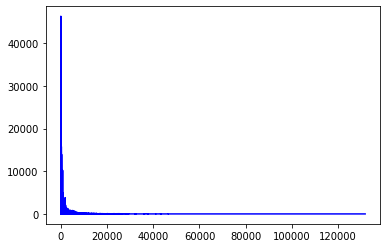

In [10]:
tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="[OOV]"
)

tokenizer.fit_on_texts(train_data_2["Body"])

# Remove 1 as the tokenizer reserves but doesn't use index 0
raw_vocab_size = len(tokenizer.word_index) - 1

# Summary of metrics:
#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)

print_marquee("Raw Vocabulary Statistics")

print(f"Raw vocabulary size: {raw_vocab_size}")

# Let's plot the graph of the dictionary size from more frequent to less frequent
plt.plot(list(np.arange(raw_vocab_size)), list(tokenizer.word_docs.values()), color='blue')
plt.show()



****************************************************************
* My vocabulary reduced to words that happen at least 50 times *
****************************************************************
New vocabulary size reduced to words happening at least 50 times: 3655
Represents a reduction of 97.2247953713687% 



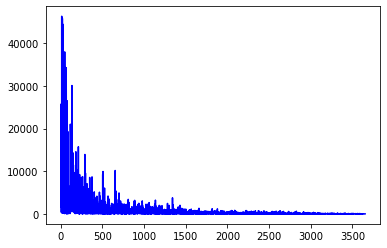

In [11]:
# Let's reduce the list of words to those that happen at least min_freq
min_freq = 50

my_vocab = {word: count for word, count in tokenizer.word_docs.items() if count >= min_freq}

print_marquee(f"My vocabulary reduced to words that happen at least {min_freq} times")

print(f"New vocabulary size reduced to words happening at least {min_freq} times: {len(my_vocab)}")
print(f"Represents a reduction of {(1 - len(my_vocab)/raw_vocab_size) * 100}% \n")

plt.plot(list(np.arange(len(my_vocab))), list(my_vocab.values()), color='blue')
plt.show()

In [12]:
def filter_words_not_in_vocab(text: str, vocabulary:dict) -> str:
    return " ".join([w for w in text.split() if w in vocabulary])

train_data_3 = train_data_2.copy()

train_data_3["Body"] = train_data_3["Body"].apply(lambda row_text: filter_words_not_in_vocab(row_text, my_vocab))

print(train_data_2.iloc[1988]["Body"])
print(train_data_3.iloc[1988]["Body"])


i have a gti9195 running lollipop 511 currently pacrom which in theory has 8gb of internal memory however i cant seem to track down what exactly has happened to all that space with a paltry 100 or so apps including system essentials installed the phone starts reporting its out of space until i move apps to the external microsd card the problem persisted even through the custom rom installation and subsequent recent rom update as well as a few factory resetscache wipesetc its been an issue for nearly 8 months now and periodically ive trawled the internet for suggestions and clues but without making any real progressit seems to me as if a large chunk of space on the phones memory is simply inaccessible and unused is this possible how can i delve deeper into whats going onive included the output of a df command in terminal emulator below i notice that there seem to be duplicates of the internal memory storageemulated0 and storageemulatedlegacy though i think one is just an alias of the ot

In [13]:
# Create another tokenizer based on the newly formed vocabulary
tokenizer = Tokenizer(
    num_words=len(my_vocab),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="[OOV]"
)

tokenizer.fit_on_texts(train_data_3["Body"])

train_sequences = tokenizer.texts_to_sequences(train_data_3["Body"])
validation_sequences = tokenizer.texts_to_sequences(val_data_2["Body"])
test_sequences = tokenizer.texts_to_sequences(test_data_2["Body"])

print_marquee("My Vocabulary Tokenizer Statistics")

# We need to substract 1 to account for the 0-index unused token (Keras reserves this but doesn't use it)
print(f"Tokenizer vocabulary size: {len(tokenizer.word_index) - 1} (compared to {len(my_vocab)} of the my vocab size)")

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_3.iloc[1988]['Body']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {val_data_2.iloc[1988]['Body']}\n {validation_sequences[1988]}")



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 3655 (compared to 3655 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 i have a running lollipop 511 currently which in theory has 8gb of internal memory however i cant seem to track down what exactly has happened to all that space with a 100 or so apps including system installed the phone starts reporting its out of space until i move apps to the external microsd card the problem even through the custom rom installation and recent rom update as well as a few factory its been an issue for nearly 8 months now and periodically ive the internet for suggestions and clues but without making any real seems to me as if a large of space on the phones memory is simply and unused is this possible how

In [14]:
import itertools 

print_marquee(f"First 50 word-index mappings")
print(dict(itertools.islice(tokenizer.index_word.items(), 50)))



********************************
* First 50 word-index mappings *
********************************
{1: '[OOV]', 2: 'the', 3: 'i', 4: 'to', 5: 'and', 6: 'a', 7: 'it', 8: 'my', 9: 'is', 10: 'on', 11: 'in', 12: 'that', 13: 'of', 14: 'have', 15: 'this', 16: 'but', 17: 'for', 18: 'phone', 19: 'with', 20: 'not', 21: 'can', 22: 'or', 23: 'app', 24: 'from', 25: 'an', 26: 'android', 27: 'there', 28: 'be', 29: 'when', 30: 'as', 31: 'do', 32: 'if', 33: 'so', 34: 'any', 35: 'are', 36: 'how', 37: 'was', 38: 'all', 39: 'device', 40: 'iphone', 41: 'me', 42: 'using', 43: 'apps', 44: 'like', 45: 'im', 46: 'which', 47: 'use', 48: 'am', 49: 'get', 50: 'way'}


Podemos ver que el mapping de tokens a un índice se está realizando correctamente. Más aún, ya que el vocabulario del tokenizer fue entrenado exclusivamente en el dataset de entrenamiento, por definición el OOV token que hemos definido como `[OOV]` no aparecerá en las secuencias de sus documentos.

Sin embargo, en los datasets de validación y de entrenamiento esto sí pasa y podemos ver que al token `[OOV]` se le asignó el índice `1` y que este token sí aparece en el documento de validación.

## 4

Transforma cada documento de la columna Body del conjunto de entrenamiento, a una vector de longitud  finita  mediante  la  función pad_sequences  de  tensorflow-keras.  Al  menos  deberás determinar e indicar cuáles consideras son los mejores valores para los argumentos maxlen y 
padding.  Una  vez  determinado  los  argumentos  de  dicha  función,  aplicarlo  al  conjunto  de validación.


---

Para poder determinar un valor óptimo convendría calcular las longitudes de todos los documentos (en función de su cantidad de palabras) y revisar sus:

1. Mínimos
1. Máximos
1. Promedio
1. Desviación estándard

Para poder poner idealmente un valor que esté en el promedio. El tipo de padding que se usará será post sólo para mantener la información significativa del vector de secuencias al principio del vector.

In [15]:
train_doc_len = pd.Series([len(doc.split()) for doc in train_data_3['Body'].tolist()])
val_doc_len = pd.Series([len(doc.split()) for doc in val_data_2['Body'].tolist()])

print_marquee("Train Metrics")
print(f"Number of documents: {len(train_doc_len)}")
print(f"Min length: {train_doc_len.min()}")
print(f"Max length: {train_doc_len.max()}")
print(f"Mean length: {train_doc_len.mean()}")
print(f"Std Dev of length: {train_doc_len.std()}")

print_marquee("Val Metrics")
print(f"Number of documents: {len(val_doc_len)}")
print(f"Min length: {val_doc_len.min()}")
print(f"Max length: {val_doc_len.max()}")
print(f"Mean length: {val_doc_len.mean()}")
print(f"Std Dev of length: {val_doc_len.std()}")




*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 0
Max length: 1221
Mean length: 86.3336967101421
Std Dev of length: 67.22155867234527


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 3
Max length: 1447
Mean length: 91.31068313953489
Std Dev of length: 71.29679122996701


Podemos ver que en el dataset de entrenamiento tenemos documentos que carecen de texto en Body, esto se debe a que habían tokens inválidos (como posts que sólo tenían bloques `<code>` y que fueron removidos durante el pre-procesamiento.

Por ahora dejaremos los registros en el dataset y dejar que el padding rellene todas sus posiciones, podemos remover estos registros durante el entrenamiento si vemos que están introduciendo ruido.

No hay muchos registros en este caso y nos permitirá ver si el padding está funcionando.

In [16]:
train_data_3[train_data_3["Body"].str.split().str.len() < 1]

,Id,Title,Body,Score,ViewCount,Label,LabelNum
25310,247464,Found in diagnostics on an iPhone 6s Plus. Any...,,0,2302,ios,1
37077,222200,Sahara fails when flashing CN ROM,,0,662,android,0
44395,176884,Why does googlequicksearchbox use so much memory?,,0,453,android,0


Las métricas que acabamos de recopilar en el dataset de prueba y validación nos muestran que el promedio de cuenta de palabras por documento es de alrededor de 86-91 con una desviación estándar para los dos datasets de alrededor de 70.

Con esto, podemos definir la longitud máxima de nuestros documentos a 150, lo que nos permitirá cubrir la mayor parte de los documentos en el dataset sin introducir padding o truncado excesivo.

In [17]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 150

train_padded = pad_sequences(train_sequences,
                             maxlen = max_len_vector,
                             padding = padding_type,
                             truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                           maxlen = max_len_vector,
                           padding = padding_type,
                           truncating = padding_type)

print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")

print_marquee("Sample of a record with no body")
print(f"Padded: {train_padded[25310]}")




************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [3, 59, 4, 69, 32, 6, 521, 659, 46, 62, 113, 1999, 11, 38, 57, 607, 522, 296, 91, 677, 129, 24, 2, 18, 42, 492, 13, 34, 229, 726, 532, 871, 4, 1693, 2, 26, 223, 360, 2, 457, 9, 11, 517, 840, 33, 228, 22, 121, 625, 3231, 305, 28, 25, 13, 522, 43, 44, 262, 35, 1069, 46, 752, 794, 44, 366, 1784, 10, 252, 173, 3040, 18, 74, 54, 492, 3439, 79, 220, 9, 79, 1027] 

 Padded:
 [3, 59, 4, 69, 32, 6, 521, 659, 46, 62, 113, 1999, 11, 38, 57, 607, 522, 296, 91, 677, 129, 24, 2, 18, 42, 492, 13, 34, 229, 726, 532, 871, 4, 1693, 2, 26, 223, 360, 2, 457, 9, 11, 517, 840, 33, 228, 22, 121, 625, 3231, 305, 28, 25, 13, 522, 43, 44, 262, 35, 1069, 46, 752, 794, 44, 366, 1784, 10, 252, 173, 3040, 18, 74, 54, 492, 3439, 79, 220, 9, 79, 1027, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
# Let's verify that the padding actually worked!

train_padded_metrics = pd.Series([len(p) for p in train_padded.tolist()])
val_padded_metrics = pd.Series([len(p) for p in val_padded.tolist()])

print_marquee("Train Padded Metrics")
print(f"Number of documents: {len(train_padded_metrics)}")
print(f"Min length: {train_padded_metrics.min()}")
print(f"Max length: {train_padded_metrics.max()}")
print(f"Mean length: {train_padded_metrics.mean()}")
print(f"Std Dev of length: {train_padded_metrics.std()}")

print_marquee("Val Padded Metrics")
print(f"Number of documents: {len(val_padded_metrics)}")
print(f"Min length: {val_padded_metrics.min()}")
print(f"Max length: {val_padded_metrics.max()}")
print(f"Mean length: {val_padded_metrics.mean()}")
print(f"Std Dev of length: {val_padded_metrics.std()}")



************************
* Train Padded Metrics *
************************
Number of documents: 51370
Min length: 150
Max length: 150
Mean length: 150.0
Std Dev of length: 0.0


**********************
* Val Padded Metrics *
**********************
Number of documents: 11008
Min length: 150
Max length: 150
Mean length: 150.0
Std Dev of length: 0.0


Con las métricas de documentos con padding podemos verificar que todos los documentos ahora tienen una longitud de máximo 150 palabras, sin importar si el documento original haya tenido más o menos palabras.

# Parte III: Modelo RNN TBD

## Preparación final del dataset

In [19]:
# Let's first prepare the final datasets in the form that will be used for training

train_final = train_data_3.copy()
X_train = train_padded
y_train = train_final["LabelNum"].to_numpy()

val_final = val_data_2.copy()
X_val = val_padded
y_val = val_final["LabelNum"].to_numpy()

test_final = test_data_2.copy()
X_test = pad_sequences(validation_sequences,
                       maxlen = max_len_vector,
                       padding = padding_type,
                       truncating = padding_type)
y_test = test_final["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")
print(f"Test final shape: X: {X_test.shape}, y: {y_test.shape}")

Train final shape X: (51370, 150), y: (51370,)
Val final shape: X: (11008, 150), y: (11008,)
Test final shape: X: (11008, 150), y: (11008,)


## Distribución de clases

Veamos qué tan distribuidas quedaron las clases imprimiendo el porcentaje de registros con clase positiva 1 (iOS). La clase negativa, por supuesto, será 0 (android).

In [20]:
# veamos qué tan bien quedaron repartidas las clases en cada conjunto:
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

print(f"Percentage of positive classes in Test: {(sum(y_test)/len(y_test)) * 100} %")

labels = ["Android", "iOS"]


Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %
Percentage of positive classes in Test: 27.679869186046513 %


Se puede apreciar que los posts sobre iOS son menos que los de Android, pero podemos ver que la distribución de clases entre los 3 splits se mantiene consistente. De momento no se hará un balance de clases, pero se debe tener esto en cuenta si es que el modelo tiene problemas en generalizar y aprender la clasificación correcta de posts sobre iOS.

## 5 TBD

Define la secuencia de capas convolucionales que consideres adecuado para construir un modelo de clasificación de red neuronal profunda basada en bloques tipo RNN. Es decir, deberás indicar la  capa  Embedding,  seguida  de  uno  o  varios  bloques  RNN  y  finalizando  con  las  capas FullyConnected que incluyan a la de salida. En la capa Embedding deberás indicar cual consideras es el tamaño de dimensión de los vectores de salida más adecuado. También deberás decidir si incluyes o no el procesamiento bidireccional.

In [ ]:
model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

#model.add(SimpleRNN(128, return_sequences=True))   # si quieres anidar varios RNN...
#model.add(SimpleRNN(128))

#model.add(GRU(128, return_sequences=True))
#model.add(GRU(128))

##model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(128))



# Bi-Directionals:

model.add(Bidirectional(SimpleRNN(128)))

#model.add(Bidirectional(GRU(128)))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

## 6 TBD

Definir los argumentos de compilación del modelo utilizados: al menos deberás indicar los argumentos de optimizer, loss y metrics. Muestra un resumen de la arquitectura del modelo.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## 7 TBD

Lleva a cabo el entrenamiento del modelo por bloques (batches), utilizando los conjuntos de entrenamiento y validación. Muestra las gráficas de las curvas de aprendizaje.

---

Para este entrenamiento se usará EarlyStopping que permita resettear los pesos a los mejores vistos antes de que tuviera que pararse el entrenamiento. Esto garantizará que tengamos el mejor modelo incluso si se vió que el modelo comenzó a sobre-entrenar.

In [ ]:
%%time

model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))   # si quieres anidar varios RNN...
#model.add(SimpleRNN(128))

#model.add(GRU(128, return_sequences=True))
#model.add(GRU(128))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))



# Bi-Directionals:

#model.add(Bidirectional(SimpleRNN(128)))

#model.add(Bidirectional(GRU(128)))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Bidirectional(LSTM(128,
#                             dropout=0.5,
#                             recurrent_dropout=0.5)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

model_2_pkl(model,
            f"{data_root_location}/ios_android_rnn_gru_ltsm.pkl")

Epoch 1/100
1606/1606 [==============================] - 653s 404ms/step - loss: 0.5951 - accuracy: 0.7207 - val_loss: 0.5893 - val_accuracy: 0.7233
Epoch 2/100
1606/1606 [==============================] - 651s 405ms/step - loss: 0.5645 - accuracy: 0.7313 - val_loss: 0.3632 - val_accuracy: 0.8136
Epoch 3/100
1606/1606 [==============================] - 649s 404ms/step - loss: 0.4338 - accuracy: 0.7867 - val_loss: 0.3170 - val_accuracy: 0.8638
Epoch 4/100
1606/1606 [==============================] - 648s 404ms/step - loss: 0.2975 - accuracy: 0.8740 - val_loss: 0.2929 - val_accuracy: 0.8782
Epoch 5/100
1606/1606 [==============================] - 678s 422ms/step - loss: 0.1310 - accuracy: 0.9467 - val_loss: 0.1323 - val_accuracy: 0.9467
Epoch 6/100
1606/1606 [==============================] - 679s 423ms/step - loss: 0.1158 - accuracy: 0.9573 - val_loss: 0.1295 - val_accuracy: 0.9524
Epoch 7/100
1606/1606 [==============================] - 650s 405ms/step - loss: 0.0944 - accuracy: 0.9628

In [ ]:
%%time

model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))   # si quieres anidar varios RNN...
#model.add(SimpleRNN(128))

#model.add(GRU(128, return_sequences=True))
#model.add(GRU(128))

#model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(128))



# Bi-Directionals:

#model.add(Bidirectional(SimpleRNN(128)))

#model.add(Bidirectional(GRU(128)))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128,
                             dropout=0.5,
                             recurrent_dropout=0.5)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

model_2_pkl(model,
            f"{data_root_location}/ios_android_rnn_bidir_lstm_dropout.pkl")

Epoch 1/100
1606/1606 [==============================] - 1564s 970ms/step - loss: 0.2408 - accuracy: 0.9060 - val_loss: 0.1059 - val_accuracy: 0.9611
Epoch 2/100
1606/1606 [==============================] - 1556s 969ms/step - loss: 0.1039 - accuracy: 0.9611 - val_loss: 0.1009 - val_accuracy: 0.9609
Epoch 3/100
1606/1606 [==============================] - 1554s 968ms/step - loss: 0.0834 - accuracy: 0.9682 - val_loss: 0.1026 - val_accuracy: 0.9483
Epoch 4/100
1606/1606 [==============================] - 1554s 968ms/step - loss: 0.0749 - accuracy: 0.9704 - val_loss: 0.0866 - val_accuracy: 0.9650
Epoch 5/100
1606/1606 [==============================] - 1551s 966ms/step - loss: 0.0774 - accuracy: 0.9686 - val_loss: 0.0882 - val_accuracy: 0.9650
Epoch 6/100
1606/1606 [==============================] - 1550s 965ms/step - loss: 0.0650 - accuracy: 0.9738 - val_loss: 0.1154 - val_accuracy: 0.9630
Epoch 7/100
1606/1606 [==============================] - 1562s 972ms/step - loss: 0.0706 - accuracy:

Epoch 1/100
1606/1606 [==============================] - 691s 428ms/step - loss: 0.2319 - accuracy: 0.9095 - val_loss: 0.1700 - val_accuracy: 0.9457
Epoch 2/100
1606/1606 [==============================] - 681s 424ms/step - loss: 0.1249 - accuracy: 0.9555 - val_loss: 0.0925 - val_accuracy: 0.9636
Epoch 3/100
1606/1606 [==============================] - 684s 426ms/step - loss: 0.0728 - accuracy: 0.9727 - val_loss: 0.0856 - val_accuracy: 0.9659
Epoch 4/100
1606/1606 [==============================] - 666s 415ms/step - loss: 0.0673 - accuracy: 0.9740 - val_loss: 0.0845 - val_accuracy: 0.9658
Epoch 5/100
1606/1606 [==============================] - 666s 414ms/step - loss: 0.0610 - accuracy: 0.9759 - val_loss: 0.0834 - val_accuracy: 0.9663
Epoch 6/100
1606/1606 [==============================] - 663s 413ms/step - loss: 0.0581 - accuracy: 0.9775 - val_loss: 0.0878 - val_accuracy: 0.9661
Epoch 7/100
1606/1606 [==============================] - 660s 411ms/step - loss: 0.0603 - accuracy: 0.9755

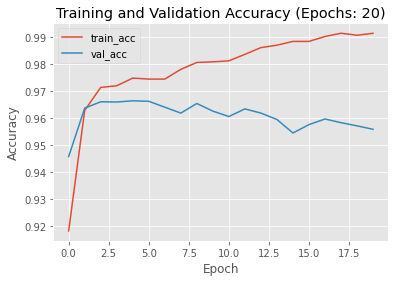

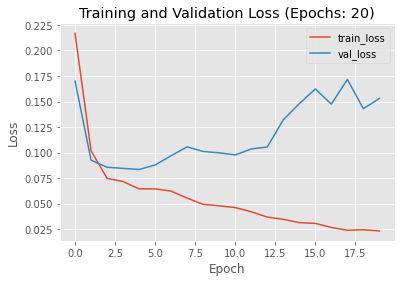

CPU times: user 6h 56min 45s, sys: 10min 57s, total: 7h 7min 43s
Wall time: 3h 45min 58s


In [ ]:
%%time

model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))   # si quieres anidar varios RNN...
#model.add(SimpleRNN(128))

#model.add(GRU(128, return_sequences=True))
#model.add(GRU(128))

#model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(128))



# Bi-Directionals:

#model.add(Bidirectional(SimpleRNN(128)))

#model.add(Bidirectional(GRU(128)))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

Epoch 1/100
1606/1606 [==============================] - 408s 252ms/step - loss: 0.5936 - accuracy: 0.7237 - val_loss: 0.5902 - val_accuracy: 0.7233
Epoch 2/100
1606/1606 [==============================] - 406s 253ms/step - loss: 0.5891 - accuracy: 0.7245 - val_loss: 0.5909 - val_accuracy: 0.7233
Epoch 3/100
1606/1606 [==============================] - 403s 251ms/step - loss: 0.5937 - accuracy: 0.7201 - val_loss: 0.5900 - val_accuracy: 0.7233
Epoch 4/100
1606/1606 [==============================] - 404s 251ms/step - loss: 0.5899 - accuracy: 0.7237 - val_loss: 0.5905 - val_accuracy: 0.7233
Epoch 5/100
1606/1606 [==============================] - 409s 255ms/step - loss: 0.5911 - accuracy: 0.7224 - val_loss: 0.5900 - val_accuracy: 0.7233
Epoch 6/100
1606/1606 [==============================] - 410s 255ms/step - loss: 0.5919 - accuracy: 0.7216 - val_loss: 0.5898 - val_accuracy: 0.7233
Epoch 7/100
1606/1606 [==============================] - 411s 256ms/step - loss: 0.5896 - accuracy: 0.7238

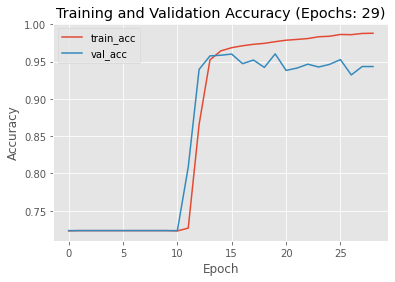

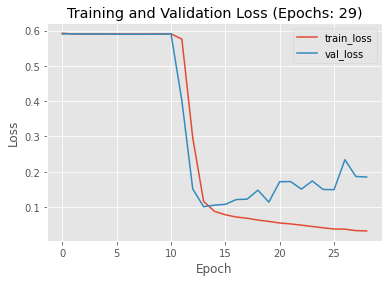

TypeError: ignored

In [21]:
%%time

model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))   # si quieres anidar varios RNN...
#model.add(SimpleRNN(128))

#model.add(GRU(128, return_sequences=True))
#model.add(GRU(128))

#model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))



# Bi-Directionals:

#model.add(Bidirectional(SimpleRNN(128)))

#model.add(Bidirectional(GRU(128)))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

model_2_pkl(model,
            f"{data_root_location}/ios_android_rnn_best_model_final.pkl")

Epoch 1/100
1606/1606 [==============================] - 209s 129ms/step - loss: 0.4038 - accuracy: 0.8326 - val_loss: 0.3146 - val_accuracy: 0.8911
Epoch 2/100
1606/1606 [==============================] - 209s 130ms/step - loss: 0.2664 - accuracy: 0.9143 - val_loss: 0.1808 - val_accuracy: 0.9480
Epoch 3/100
1606/1606 [==============================] - 210s 131ms/step - loss: 0.1825 - accuracy: 0.9487 - val_loss: 0.1873 - val_accuracy: 0.9478
Epoch 4/100
1606/1606 [==============================] - 208s 129ms/step - loss: 0.1811 - accuracy: 0.9501 - val_loss: 0.1889 - val_accuracy: 0.9499
Epoch 5/100
1606/1606 [==============================] - 222s 138ms/step - loss: 0.1929 - accuracy: 0.9420 - val_loss: 0.1958 - val_accuracy: 0.9479
Epoch 6/100
1606/1606 [==============================] - 217s 135ms/step - loss: 0.2417 - accuracy: 0.9114 - val_loss: 0.2260 - val_accuracy: 0.9225
Epoch 7/100
1606/1606 [==============================] - 213s 132ms/step - loss: 0.2115 - accuracy: 0.9213

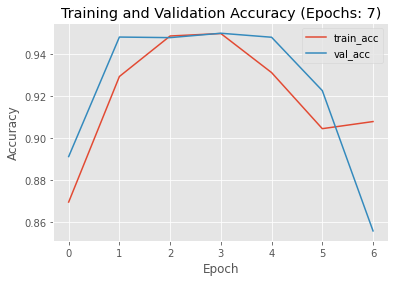

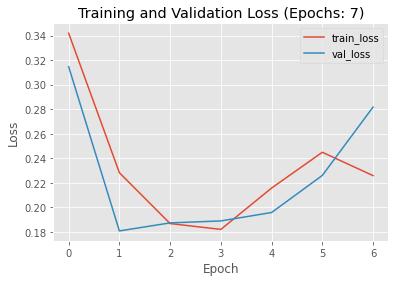

CPU times: user 43min 14s, sys: 1min 22s, total: 44min 36s
Wall time: 25min 6s


In [ ]:
%%time

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=5,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## 8 TBD
Muestra la matriz de confusión del modelo, utilizando los datos del conjunto de validación.

In [ ]:
val_model_predictions = model.predict(X_val,
                                      batch_size=batch_size)
    
print_dataset_prediction_report(val_model_predictions,
                                y_val,
                                labels)



*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

     Android       0.95      0.98      0.96      7962
         iOS       0.94      0.86      0.90      3046

    accuracy                           0.95     11008
   macro avg       0.95      0.92      0.93     11008
weighted avg       0.95      0.95      0.95     11008



********************
* Confusion Matrix *
********************
[[7804  158]
 [ 414 2632]]


## 9 TBD

Reporta tus conclusiones. 